# <u>MODELLING WORKBOOK</u>

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;In this work book, I performed following:

* Deeper EDA on data

* Compare model performances of Log Reg, KNN, RF, SVM
and XGB with original data vs upsampled data via SMOTE

* Perform five Gridsearches on five models above with intend to ensemble models with best parameters for Voting classifier

* Decide which model performed the best through metrics like accuracies, precision, recall and AUC-ROC curve.

* Analyze the reason for low precisions on all models

* Quick modelling based on my reasons and see if I could get improvement in precisions

* Use the model on unseen data and analyze

In [198]:
# Usual Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image

In [199]:
# For Data split
from sklearn.model_selection import train_test_split

# For Model evaluation
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

# For Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

In [200]:
# Read in prepared data frame
df_scaled = pd.read_csv('data/scaled.csv')

In [201]:
# Preview
df_scaled.head()

,batter_age,b_runs,b_hits,doubles,triples,homeruns,sb,cs,walks,b_strikeouts,...,hbp,era_plus,so_walk,p_left_on_base,defensive_efficiency,errors,Rtot,team,year,playoff_appearance
0,0.941176,0.685934,0.587571,0.468342,0.000000,0.488771,0.214337,0.500000,0.215278,0.000000,...,0.239003,0.465116,0.733333,0.212781,0.633333,0.168675,0.670956,ATL,1969,1
1,0.676471,0.956616,0.740113,0.874904,0.233333,0.799160,0.383257,0.442308,0.732639,0.294979,...,0.106224,1.000000,0.504762,0.030994,1.000000,0.000000,1.000000,BAL,1969,1
2,0.088235,0.845882,0.502825,0.874904,0.500000,1.000000,0.082139,0.480769,0.815972,0.539749,...,0.796676,0.348837,0.095238,0.977980,0.283333,0.674699,0.403608,BOS,1969,0
3,0.088235,0.174592,0.029687,0.000000,0.227403,0.000000,0.175182,0.322322,0.311925,0.540378,...,0.868035,0.348837,0.419048,0.000000,0.550000,0.411634,0.541635,LAA,1969,0
4,1.000000,0.761549,0.532235,0.663085,0.591820,0.489947,0.000000,0.188532,0.460314,0.538299,...,0.287390,0.883721,0.828571,0.407563,0.283333,0.411634,0.357684,CHC,1969,0


In [5]:
# Drop those rows as there were no playoff in year 1994 due to players' strike
df_scaled = df_scaled.drop(df_scaled[df_scaled['year'] == 1994].index, axis = 0)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Before moving onto the modelling, I would like to do a quick EDA on data. I want to take a look at the difference between the playoff team and non-playoff team. I will group the data into two groups by `playoff_appearance` and look at the % difference in features between two groups

In [6]:
# Exploratory Analysis

grpd_playoffs = df_scaled.groupby('playoff_appearance')
playoff_pct_changes = grpd_playoffs.mean().pct_change().iloc[1,:].sort_values(ascending = False)

C:\Users\DK\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


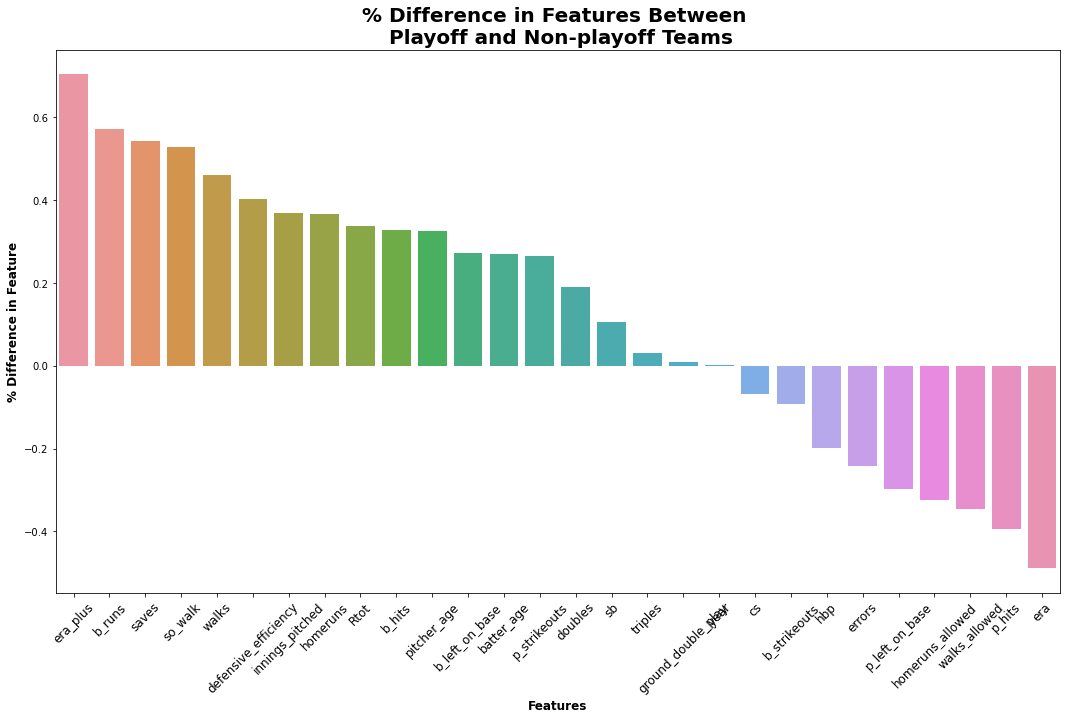

In [197]:
plt.figure(figsize = (18, 10))
sns.barplot(playoff_pct_changes.index, playoff_pct_changes)
plt.xticks(rotation = 45)
plt.ylabel('% Difference in Feature', fontweight = 'bold', fontsize = 12)
plt.xlabel('Features', fontweight = 'bold', fontsize = 12)
plt.title('% Difference in Features Between \n Playoff and Non-playoff Teams', fontsize = 20, fontweight = 'extra bold')
plt.xticks(size = 12)

plt.show()

In [8]:
# Check the magnitude of % difference
grpd_playoffs.mean().pct_change().iloc[1,:].abs().sort_values(ascending = False)

era_plus                0.703824
b_runs                  0.572348
saves                   0.543428
so_walk                 0.527636
era                     0.489333
walks                   0.459735
defensive_efficiency    0.403163
p_hits                  0.394479
innings_pitched         0.368144
homeruns                0.365788
walks_allowed           0.346550
Rtot                    0.337757
b_hits                  0.328812
pitcher_age             0.326045
homeruns_allowed        0.324927
p_left_on_base          0.296728
b_left_on_base          0.272374
batter_age              0.269041
p_strikeouts            0.265349
errors                  0.241959
hbp                     0.199391
doubles                 0.189733
sb                      0.105263
b_strikeouts            0.093097
cs                      0.069043
triples                 0.031778
ground_double_play      0.008282
year                    0.002809
Name: 1, dtype: float64

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Top three features that have biggest % difference in magnitude are `era_plus`, `b_runs`, `saves`. It makes sense that these stats top the list. You allowing fewer runs, scoring more and preserving the lead are definitely components of playoff teams and I would not expect any differently.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;`era` is the fifth biggest difference in magnitude and having negative difference is not a bad thing. The stats like `era` and `p_hits` that are in negative in terms of changes are better in lower numbers. For those unfamiliar with baseball stats, you might wonder what the diffences are between `era_plus` and `era`. It is abbreviation for earned run average and is pitching statistics. To put it simply, it is how many scores do you allow opponents to score over a game hence lower means fewer runs so gives you better chance to be a playoff team. `era_plus` is adjusted era according to pitcher's ballpark (yes they affect `era` as some stadiums are more favorable to hitters) and `era` of the pitcher's league. 100 is the average pitcher and anything above means the pitcher performed better than average. Therefore greater `era_plus` indicates better performances of team's pitching staffs. 

In [9]:
# Electing to use data upto 2018. Will leave out 2019 and 2020 as unseen data

# 2020 is an odd season with smaller number of games and expended playoff. Will see if it had any effects

# X is every features minus last three features 'team', 'year', 'playoff_appearance'
X = df_scaled.loc[df_scaled['year'] < 2019].iloc[:,:-3]

# y is the playoff_appearance
y = df_scaled['playoff_appearance'].loc[df_scaled['year'] < 2019]

In [10]:
# Double check X
X

,batter_age,b_runs,b_hits,doubles,triples,homeruns,sb,cs,walks,b_strikeouts,...,walks_allowed,p_strikeouts,saves,hbp,era_plus,so_walk,p_left_on_base,defensive_efficiency,errors,Rtot
0,0.941176,0.685934,0.587571,0.468342,0.000000,0.488771,0.214337,0.500000,0.215278,0.000000,...,0.063830,0.282276,0.935277,0.239003,0.465116,0.733333,0.212781,0.633333,0.168675,0.670956
1,0.676471,0.956616,0.740113,0.874904,0.233333,0.799160,0.383257,0.442308,0.732639,0.294979,...,0.276596,0.291028,0.710810,0.106224,1.000000,0.504762,0.030994,1.000000,0.000000,1.000000
2,0.088235,0.845882,0.502825,0.874904,0.500000,1.000000,0.082139,0.480769,0.815972,0.539749,...,0.939716,0.374179,0.897866,0.796676,0.348837,0.095238,0.977980,0.283333,0.674699,0.403608
3,0.088235,0.174592,0.029687,0.000000,0.227403,0.000000,0.175182,0.322322,0.311925,0.540378,...,0.332724,0.252890,0.814092,0.868035,0.348837,0.419048,0.000000,0.550000,0.411634,0.541635
4,1.000000,0.761549,0.532235,0.663085,0.591820,0.489947,0.000000,0.188532,0.460314,0.538299,...,0.184702,0.539958,0.367914,0.287390,0.883721,0.828571,0.407563,0.283333,0.411634,0.357684
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1373,0.454545,0.587071,0.414226,0.187061,0.000000,0.551391,0.280000,0.366667,0.465999,0.471605,...,0.762846,0.381625,0.468750,0.500000,0.377358,0.164103,1.000000,0.255814,1.000000,0.304742
1374,0.181818,0.435311,0.606695,0.384597,0.829268,0.153431,0.930000,1.000000,0.533863,0.491358,...,0.399209,0.530035,0.750000,0.181818,0.547170,0.466667,0.000000,0.790698,0.314286,0.787870
1375,0.272727,0.509426,0.158996,0.323817,0.365854,0.471799,0.390000,0.466667,0.601726,0.728395,...,0.359684,0.000000,0.437500,0.613636,0.301887,0.179487,0.417840,0.186047,0.814286,0.587187
1376,0.727273,0.410605,0.276151,0.734085,0.170732,0.638219,0.120000,0.300000,0.348368,0.488889,...,0.596838,0.312721,0.343750,0.500000,0.132075,0.220513,0.615023,0.093023,0.542857,0.000000


In [11]:
# double check y
y

0       1
1       1
2       0
3       0
4       0
       ..
1373    0
1374    0
1375    0
1376    0
1377    0
Name: playoff_appearance, Length: 1350, dtype: int64

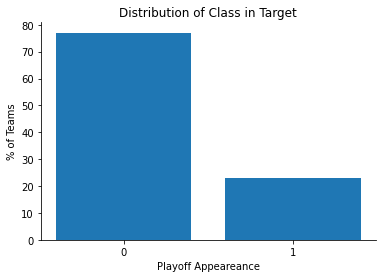

In [12]:
values, counts = np.unique(y, return_counts=True)
normalized_counts = counts/counts.sum()

plt.bar(["0", "1"], normalized_counts * 100)
plt.xlabel('Playoff Appeareance')
plt.ylabel('% of Teams')
sns.despine()
plt.title("Distribution of Class in Target")
plt.show()

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;There is big class imbalance in the target .This is due to how playoff was and is formatted. From 1969 to 1993, there were only 4 teams that made the playoff whereas in recent years, after couple of expansion in playoff format, there are 10 teams that make the playoff. There are 30 teams in modern MLB so imbalance in the target is always present and is more extreme in my case as I use pre-playoff expansion data as well. This will cause poor performance on the minority class, which is the most important part of the project. To address this, I will use SMOTE to create synthetic data in the minority class.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;General idea of SMOTE is by selecting data in minority class that are close in feature space and 'drawing' a line among selected data. Then a synthetic point is picked at a point along the line. SMOTE is effective because new snythetic data from the minority class are plausible and relatively close in feature space. General downside is that synthetic data are created without considering the majority class resulting in ambiguous point if there is a strong overlap in classes. However, there is a parameter that might combat this and will try later part of modelling.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;SMOTE in imblearn package will add synthetic data on top of original minority data. This is nice as it ensures all my original data is included for modelling.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;I will be using five different models (Log Reg, KNN, RF, SVM, XGB) and Voting Classifier using best parameters of these different models found using Gridsearch. I will present base models with regular imbalance data and with upsampled data using SMOTE to showcase the effect of upsampling.

In [13]:
# Perform train_test_split with stratify on y as it is imbalanced and make sure train and validation gets same portion of 0, 1 in y

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 5, stratify= y, test_size=0.2)

In [14]:
# Import SMOTE package to address the imbalance on target y
from imblearn.over_sampling import SMOTE

In [15]:
# In order to have same number of target class, I put 1 in sampling_strategy parameter
sm = SMOTE(sampling_strategy = 1, random_state = 777, n_jobs = -1)

X_train_up, y_train_up = sm.fit_sample(X_train, y_train)

In [16]:
# Check the number of classes in target 
len(y_train_up[y_train_up == 0]), len(y_train_up[y_train_up == 1])

(832, 832)

In [17]:
# Original size of y_train in class 1
len(y_train[y_train == 1])

248

In [18]:
# Compare number of data in original vs upsampled
X_train.shape[0], X_train_up.shape[0]

(1080, 1664)

SMOTE created 584 synthetic data in class 1 to match the size of data in class 0! 

In [19]:
# Make test set 1 and 2. First test set is for year 2019 and second is for year 2020

# These will not be used in modelling and remain 'unseen'
X_2019 = df_scaled.loc[df_scaled['year'] == 2019].iloc[:, :-3]
X_2020 = df_scaled.loc[df_scaled['year'] == 2020].iloc[:, :-3]

In [20]:
# Target of the unseen data. Same as the cell above 2019 and 2020
y_2019 = df_scaled['playoff_appearance'].loc[df_scaled['year'] == 2019]
y_2020 = df_scaled['playoff_appearance'].loc[df_scaled['year'] == 2020]

In [21]:
X_2019

,batter_age,b_runs,b_hits,doubles,triples,homeruns,sb,cs,walks,b_strikeouts,...,walks_allowed,p_strikeouts,saves,hbp,era_plus,so_walk,p_left_on_base,defensive_efficiency,errors,Rtot
1378,0.700,0.636247,0.505495,0.528926,0.948271,0.459627,0.582524,0.108108,0.603253,0.442007,...,0.556054,0.446712,0.720000,0.428571,0.522727,0.372881,0.641791,0.509804,0.303030,0.947915
1379,0.525,0.753767,0.553114,0.438017,0.494750,0.639752,0.592233,0.486486,0.901758,0.685795,...,0.699552,0.369615,0.680000,0.571429,0.636364,0.242938,0.920398,0.372549,0.181818,0.648429
1380,0.150,0.401206,0.358974,0.231405,0.329834,0.416149,0.543689,0.540541,0.308526,0.612886,...,0.757848,0.040816,0.000000,0.795918,0.000000,0.062147,0.611940,0.431373,0.636364,0.667961
1381,0.350,0.882480,1.000000,1.000000,0.412292,0.614907,0.388350,0.540541,0.792180,0.492132,...,0.955157,0.913832,0.240000,0.714286,0.454545,0.333333,0.975124,0.137255,0.333333,0.492175
1382,0.450,0.639045,0.355311,0.380165,0.371063,0.683230,0.165049,0.378378,0.758173,0.669846,...,0.636771,0.485261,0.440000,0.795918,0.545455,0.333333,0.915423,0.294118,0.787879,0.720045
1383,0.425,0.354751,0.626237,0.310867,0.128809,0.230624,0.343605,0.491187,0.000000,0.894543,...,0.868228,0.204420,0.248199,0.210546,0.250000,0.079096,0.660517,0.235294,0.783738,0.517530
1384,0.475,0.322859,0.172161,0.090909,0.412292,0.503106,0.504854,0.756757,0.421883,0.615165,...,0.645740,0.730159,0.760000,0.346939,0.659091,0.446328,0.343284,0.647059,0.378788,0.733066
1385,0.450,0.513130,0.267399,0.512397,0.041229,0.478261,0.728155,0.675676,0.690159,0.378212,...,0.260090,0.630385,0.600000,0.428571,0.977273,0.700565,0.373134,0.568627,0.257576,0.921873
1386,0.575,0.697805,0.809524,0.818182,0.989501,0.484472,0.417476,0.567568,0.410547,0.767817,...,0.883408,0.077098,0.040000,0.326531,0.227273,0.022599,0.776119,0.215686,0.469697,0.733066
1387,0.425,0.000000,0.220804,0.576972,1.000000,0.024382,0.284991,0.273628,0.049426,1.000000,...,0.660669,0.332193,0.167702,0.580175,0.181818,0.248588,0.850746,0.000000,0.677019,0.000000


<hr style="border:2px solid gray"> </hr>

## Base Modelling

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;This is very basic modelling of five different machine learning models. There is no k-fold cross validation here. This section is intended to look at overview of different models and compare the original data and umsampled data (upsampled training data to be exact). Cross validation will come when I perform grid search in Hyperparameter Optimization Section.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;I will model ten different base models using five different machine learning models with original data and upsampled data and store results for analysis of these models. In order to avoid any confusion, here is the naming convention I used:

Name of machine learning model [LR / KNN / RF / SVM / XGB] followed by _ and [o or up] for `original` or `upsampled` data

Random state always set at 777 for reproducibility

In [22]:
result_df = pd.DataFrame(columns = ['train_o', 'test_o', 'train_up', 'test_up',
                                   'precision_o', 'recall_o', 'precision_up', 'recall_up'],
                        index = ['LR', 'KNN', 'RF', 'SVM', 'XGB'])

In [23]:
result_df

,train_o,test_o,train_up,test_up,precision_o,recall_o,precision_up,recall_up
LR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
KNN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
RF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SVM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
XGB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
# Storage for the results
train_o = []
test_o = []
train_up = []
test_up = []
precision_o = []
recall_o = []
precision_up = []
recall_up = []

### <u>Logistic Regression</u>

In [25]:
### With original data ###

# 1. Instantiate. lbfgs is default but wanted to articulate 
LR_o = LogisticRegression(solver = 'lbfgs')

# 2. Fit
LR_o.fit(X_train, y_train)

# 3. Evaluate
LR_train_acc_o = LR_o.score(X_train, y_train)
LR_test_acc_o = LR_o.score(X_test, y_test)

In [26]:
# Will quickly look at coefficients and what they say about the model
log_coef = LR_o.coef_

In [27]:
# Creating coefficients df 
coefficients = pd.concat([pd.DataFrame(X_train.columns, columns = ['name_of_features']),
                          pd.DataFrame(np.transpose(log_coef), columns = ['coef'])], axis = 1)

In [28]:
# Sort by descending order of coefficients
coefficients = coefficients.sort_values('coef', ascending = False)

In [29]:
coefficients

,name_of_features,coef
1,b_runs,3.680145
19,saves,2.717836
8,walks,1.859757
21,era_plus,1.434075
5,homeruns,1.246938
26,Rtot,0.914340
2,b_hits,0.679525
12,pitcher_age,0.625559
4,triples,0.581046
23,p_left_on_base,0.544148


In [30]:
# Since there are too many coefficients for graphs, I decided to take only top 5 and bottom 5
coefficients_top3 = coefficients.iloc[:3]
coefficients_bottom2 = coefficients.iloc[-2:]
coefficients_five = pd.concat([coefficients_top3, coefficients_bottom2])

In [31]:
coefficients_five

,name_of_features,coef
1,b_runs,3.680145
19,saves,2.717836
8,walks,1.859757
16,homeruns_allowed,-1.846323
13,era,-1.944871


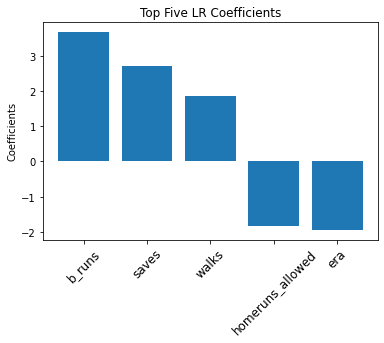

In [32]:
plt.bar(coefficients_five['name_of_features'], coefficients_five['coef'])
plt.xticks(rotation = 45, fontsize = 12)
plt.title('Top Five LR Coefficients')
plt.ylabel('Coefficients')
plt.show()

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Top five features that affect most in outcome are `b_runs`, `saves`, `era`, `walks`, `homeruns_allowed`. Just like earlier in percentage difference in playoff teams and non-playoff teams, magnitude is important. These features with negative coefficients are stats that are good when lower. This list of top five features tell me nothing revolutionary. Again, it shows importance of getting on base free (`walks`), score more (`b_runs`) and allow opponents to score fewer runs by having lower `homeruns_allowed` and `era`. Once you have the lead, maintain the lead and close out (`saves`). Essentially it is telling us the winning recipe and how to make teams playoff-bound. 

In [33]:
print(f'Training accuracy of logistic regression using original data is {round(LR_train_acc_o * 100,2)}%')

print(f'Test accuracy of logistic regression using original data is {round(LR_test_acc_o * 100,2)}%')

Training accuracy of logistic regression using original data is 89.63%
Test accuracy of logistic regression using original data is 83.7%


In [34]:
# Classification report and ROC AUC Score for test set
print(classification_report(y_test, LR_o.predict(X_test)))
print(f'ROC AUC Score: {round(roc_auc_score(y_test, LR_o.predict(X_test)),2)}')

              precision    recall  f1-score   support

           0       0.87      0.92      0.90       208
           1       0.68      0.55      0.61        62

    accuracy                           0.84       270
   macro avg       0.78      0.74      0.75       270
weighted avg       0.83      0.84      0.83       270

ROC AUC Score: 0.74


In [35]:
# Store log reg accuracies with original data
train_o.append(LR_train_acc_o)
test_o.append(LR_test_acc_o)

In [36]:
# Store log reg precision and recall of original data
precision_o.append(classification_report(y_test, LR_o.predict(X_test), output_dict = True)['1']['precision'])
recall_o.append(classification_report(y_test, LR_o.predict(X_test), output_dict = True)['1']['recall'])

In [37]:
### With Upsampled data ###

# 1. Instantiate. lbfgs is default but wanted to articulate 
LR_up = LogisticRegression(solver = 'lbfgs')

# 2. Fit
LR_up.fit(X_train_up, y_train_up)

# 3. Evaluate
LR_train_acc_up = LR_up.score(X_train_up, y_train_up)
LR_test_acc_up = LR_up.score(X_test, y_test)

In [38]:
print(f'Training accuracy of logistic regression using upsampled data is {round(LR_train_acc_up * 100,2)}%')

print(f'Test accuracy of logistic regression using upsampled data  is {round(LR_test_acc_up * 100,2)}%')

Training accuracy of logistic regression using upsampled data is 89.18%
Test accuracy of logistic regression using upsampled data  is 81.85%


In [39]:
# Classification report and ROC AUC Score for test set
print(classification_report(y_test, LR_up.predict(X_test)))
print(f'ROC AUC Score: {round(roc_auc_score(y_test, LR_up.predict(X_test)),2)}')

              precision    recall  f1-score   support

           0       0.94      0.82      0.87       208
           1       0.57      0.82      0.68        62

    accuracy                           0.82       270
   macro avg       0.76      0.82      0.77       270
weighted avg       0.86      0.82      0.83       270

ROC AUC Score: 0.82


In [40]:
# Store log reg accuracies with upsampled data
train_up.append(LR_train_acc_up)
test_up.append(LR_test_acc_up)

In [41]:
# Store log reg precision and recall of upsampled data
precision_up.append(classification_report(y_test, LR_up.predict(X_test), output_dict = True)['1']['precision'])
recall_up.append(classification_report(y_test, LR_up.predict(X_test), output_dict = True)['1']['recall'])

### <u>KNN</u>

In [42]:
### With original data ###

# 1. Instantiate
KNN_o = KNeighborsClassifier()

# 2. Fit
KNN_o.fit(X_train, y_train)

# 3. Evaluate
KNN_train_acc_o = KNN_o.score(X_train, y_train)
KNN_test_acc_o = KNN_o.score(X_test, y_test)

In [43]:
print(f'Training accuracy of KNN using original data is {round(KNN_train_acc_o * 100,2)}%')

print(f'Test accuracy KNN using original data is {round(KNN_test_acc_o * 100,2)}%')

Training accuracy of KNN using original data is 90.46%
Test accuracy KNN using original data is 78.52%


In [44]:
# Classification report and ROC AUC Score
print(classification_report(y_test, KNN_o.predict(X_test)))
print(f'ROC AUC Score: {round(roc_auc_score(y_test, KNN_o.predict(X_test)),2)}')

# note precision and recall curve

              precision    recall  f1-score   support

           0       0.84      0.89      0.87       208
           1       0.54      0.42      0.47        62

    accuracy                           0.79       270
   macro avg       0.69      0.66      0.67       270
weighted avg       0.77      0.79      0.78       270

ROC AUC Score: 0.66


In [45]:
# Store KNN accuracies with upsampled data
train_o.append(KNN_train_acc_o)
test_o.append(KNN_test_acc_o)

In [46]:
# Store KNN precision and recall of upsampled data
precision_o.append(classification_report(y_test, KNN_o.predict(X_test), output_dict = True)['1']['precision'])
recall_o.append(classification_report(y_test, KNN_o.predict(X_test), output_dict = True)['1']['recall'])

In [47]:
### With upsampled data ###

# 1. Instantiate
KNN_up = KNeighborsClassifier()

# 2. Fit
KNN_up.fit(X_train_up, y_train_up)

# 3. Evaluate
KNN_train_acc_up = KNN_up.score(X_train_up, y_train_up)
KNN_test_acc_up = KNN_up.score(X_test, y_test)

In [48]:
print(f'Training accuracy of KNN using upsampled data is {round(KNN_train_acc_up * 100,2)}%')

print(f'Test accuracy KNN using upsampled data is {round(KNN_test_acc_up * 100,2)}%')

Training accuracy of KNN using upsampled data is 90.62%
Test accuracy KNN using upsampled data is 72.96%


In [49]:
# Classification report and ROC AUC Score
print(classification_report(y_test, KNN_up.predict(X_test)))
print(f'ROC AUC Score: {round(roc_auc_score(y_test, KNN_up.predict(X_test)),2)}')

# note precision and recall curve

              precision    recall  f1-score   support

           0       0.92      0.71      0.80       208
           1       0.45      0.81      0.58        62

    accuracy                           0.73       270
   macro avg       0.69      0.76      0.69       270
weighted avg       0.82      0.73      0.75       270

ROC AUC Score: 0.76


In [50]:
# Store KNN accuracies with upsampled data
train_up.append(KNN_train_acc_up)
test_up.append(KNN_test_acc_up)

In [51]:
# Store log reg precision and recall of upsampled data
precision_up.append(classification_report(y_test, KNN_up.predict(X_test), output_dict = True)['1']['precision'])
recall_up.append(classification_report(y_test, KNN_up.predict(X_test), output_dict = True)['1']['recall'])

### <u>Random Forest</u>

In [52]:
### With original data ###

# 1. Instantiate
RF_o = RandomForestClassifier(max_depth = 4)

# 2. Fit
RF_o.fit(X_train, y_train)

# 3. Evaluate
RF_train_acc_o = RF_o.score(X_train, y_train)
RF_test_acc_o = RF_o.score(X_test, y_test)

print(f'Training accuracy is {round(RF_train_acc_o * 100,2)}%')

print(f'Validation accuracy is {round(RF_test_acc_o * 100,2)}%')

print(classification_report(y_test, RF_o.predict(X_test)))
print(f'ROC AUC Score: {round(roc_auc_score(y_test, RF_o.predict(X_test)),2)}')

Training accuracy is 90.74%
Validation accuracy is 81.48%
              precision    recall  f1-score   support

           0       0.84      0.94      0.89       208
           1       0.67      0.39      0.49        62

    accuracy                           0.81       270
   macro avg       0.75      0.66      0.69       270
weighted avg       0.80      0.81      0.80       270

ROC AUC Score: 0.66


In [53]:
# Store RF accuracies with upsampled data
train_o.append(RF_train_acc_o)
test_o.append(RF_test_acc_o)

In [54]:
# Store RF precision and recall of upsampled data
precision_o.append(classification_report(y_test, RF_o.predict(X_test), output_dict = True)['1']['precision'])
recall_o.append(classification_report(y_test, RF_o.predict(X_test), output_dict = True)['1']['recall'])

In [55]:
### With upsampled data ###

# 1. Instantiate
RF_up = RandomForestClassifier(max_depth = 4)

# 2. Fit
RF_up.fit(X_train_up, y_train_up)

# 3. Evaluate
RF_train_acc_up = RF_up.score(X_train_up, y_train_up)
RF_test_acc_up = RF_up.score(X_test, y_test)

print(f'Training accuracy is {round(RF_train_acc_up * 100,2)}%')

print(f'Validation accuracy is {round(RF_test_acc_up * 100,2)}%')

print(classification_report(y_test, RF_up.predict(X_test)))
print(f'ROC AUC Score: {round(roc_auc_score(y_test, RF_up.predict(X_test)),2)}')

Training accuracy is 91.71%
Validation accuracy is 80.37%
              precision    recall  f1-score   support

           0       0.92      0.81      0.86       208
           1       0.55      0.77      0.64        62

    accuracy                           0.80       270
   macro avg       0.74      0.79      0.75       270
weighted avg       0.84      0.80      0.81       270

ROC AUC Score: 0.79


In [56]:
# Store RF accuracies with upsampled data
train_up.append(RF_train_acc_up)
test_up.append(RF_test_acc_up)

In [57]:
# Store RF precision and recall of upsampled data
precision_up.append(classification_report(y_test, RF_up.predict(X_test), output_dict = True)['1']['precision'])
recall_up.append(classification_report(y_test, RF_up.predict(X_test), output_dict = True)['1']['recall'])

### <u>Support Vector Machine</u>

In [58]:
### With original data ###

# 1. Instantiate
# the default kernel is a Radial Basis Function transformation
SVM_o = SVC(kernel='rbf')

# 2. Fit
SVM_o.fit(X_train, y_train)

# 3. Evaluate
SVM_train_acc_o = SVM_o.score(X_train, y_train)
SVM_test_acc_o = SVM_o.score(X_test, y_test)

In [59]:
print(f'Training accuracy of SVM RBF kernel is {round(SVM_train_acc_o * 100,2)}%')

print(f'Validation accuracy of SVM RBF kernal is {round(SVM_test_acc_o * 100,2)}%')

print(classification_report(y_test, SVM_o.predict(X_test)))
print(f'ROC AUC Score: {round(roc_auc_score(y_test, SVM_o.predict(X_test)),2)}')

Training accuracy of SVM RBF kernel is 93.98%
Validation accuracy of SVM RBF kernal is 82.59%
              precision    recall  f1-score   support

           0       0.87      0.91      0.89       208
           1       0.64      0.55      0.59        62

    accuracy                           0.83       270
   macro avg       0.76      0.73      0.74       270
weighted avg       0.82      0.83      0.82       270

ROC AUC Score: 0.73


In [60]:
# Store SVM accuracies with upsampled data
train_o.append(SVM_train_acc_o)
test_o.append(SVM_test_acc_o)

In [61]:
# Store SVM precision and recall of upsampled data
precision_o.append(classification_report(y_test, SVM_o.predict(X_test), output_dict = True)['1']['precision'])
recall_o.append(classification_report(y_test, SVM_o.predict(X_test), output_dict = True)['1']['recall'])

In [62]:
### With upsampled data ###

# 1. Instantiate
# the default kernel is a Radial Basis Function transformation
SVM_up = SVC(kernel = 'rbf')

# 2. Fit
SVM_up.fit(X_train_up, y_train_up)

# 3. Evaluate
SVM_train_acc_up = SVM_up.score(X_train_up, y_train_up)
SVM_test_acc_up = SVM_up.score(X_test, y_test)

In [63]:
print(f'Training accuracy of SVM RBF kernel is {round(SVM_train_acc_up * 100,2)}%')

print(f'Validation accuracy of SVM RBF kernal is {round(SVM_test_acc_up * 100,2)}%')

print(classification_report(y_test, SVM_up.predict(X_test)))
print(f'ROC AUC Score: {round(roc_auc_score(y_test, SVM_up.predict(X_test)),2)}')

Training accuracy of SVM RBF kernel is 96.21%
Validation accuracy of SVM RBF kernal is 83.7%
              precision    recall  f1-score   support

           0       0.92      0.87      0.89       208
           1       0.62      0.74      0.68        62

    accuracy                           0.84       270
   macro avg       0.77      0.80      0.78       270
weighted avg       0.85      0.84      0.84       270

ROC AUC Score: 0.8


In [64]:
# Store SVM accuracies with upsampled data
train_up.append(SVM_train_acc_up)
test_up.append(SVM_test_acc_up)

In [65]:
# Store SVM precision and recall of upsampled data
precision_up.append(classification_report(y_test, SVM_up.predict(X_test), output_dict = True)['1']['precision'])
recall_up.append(classification_report(y_test, SVM_up.predict(X_test), output_dict = True)['1']['recall'])

### <u>Extreme Gradient Boost</u>

In [66]:
### With original data ###

# 1. Instantiate
XGB_o = XGBClassifier(max_depth = 2)

# 2. Fit
XGB_o.fit(X_train, y_train)

# 3. Evaluate
XGB_train_acc_o = XGB_o.score(X_train, y_train)
XGB_test_acc_o = XGB_o.score(X_test, y_test)

In [67]:
print(f'Training accuracy is {round(XGB_train_acc_o * 100,2)}%')

print(f'Test accuracy is {round(XGB_test_acc_o * 100,2)}%')

Training accuracy is 98.7%
Test accuracy is 81.85%


In [68]:
print(classification_report(y_test, XGB_o.predict(X_test)))
print(f'ROC AUC Score: {round(roc_auc_score(y_test, XGB_o.predict(X_test)),2)}')

              precision    recall  f1-score   support

           0       0.87      0.89      0.88       208
           1       0.61      0.56      0.59        62

    accuracy                           0.82       270
   macro avg       0.74      0.73      0.74       270
weighted avg       0.81      0.82      0.82       270

ROC AUC Score: 0.73


In [69]:
# Store XGB accuracies with original data
train_o.append(XGB_train_acc_o)
test_o.append(XGB_test_acc_o)

In [70]:
# Store XGB precision and recall of upsampled data
precision_o.append(classification_report(y_test, XGB_o.predict(X_test), output_dict = True)['1']['precision'])
recall_o.append(classification_report(y_test, XGB_o.predict(X_test), output_dict = True)['1']['recall'])

In [71]:
### With upsampled data ###

# 1. Instantiate
XGB_up = XGBClassifier(max_depth = 2)

# 2. Fit
XGB_up.fit(X_train_up, y_train_up)

# 3. Evaluate
XGB_train_acc_up = XGB_up.score(X_train_up, y_train_up)
XGB_test_acc_up = XGB_up.score(X_test, y_test)

In [72]:
print(f'Training accuracy is {round(XGB_train_acc_up * 100,2)}%')

print(f'Test accuracy is {round(XGB_test_acc_up * 100,2)}%')

Training accuracy is 98.02%
Test accuracy is 82.22%


In [73]:
print(classification_report(y_test, XGB_up.predict(X_test)))
print(f'ROC AUC Score: {round(roc_auc_score(y_test, XGB_up.predict(X_test)),2)}')

              precision    recall  f1-score   support

           0       0.90      0.87      0.88       208
           1       0.60      0.68      0.64        62

    accuracy                           0.82       270
   macro avg       0.75      0.77      0.76       270
weighted avg       0.83      0.82      0.83       270

ROC AUC Score: 0.77


In [74]:
# Store XGB accuracies with upsampled data
train_up.append(XGB_train_acc_up)
test_up.append(XGB_test_acc_up)

In [75]:
# Store XGB precision and recall of upsampled data
precision_up.append(classification_report(y_test, XGB_up.predict(X_test), output_dict = True)['1']['precision'])
recall_up.append(classification_report(y_test, XGB_up.predict(X_test), output_dict = True)['1']['recall'])

In [76]:
# Add the resulting list to respective result_df columns
result_df['train_o'] = train_o
result_df['test_o'] = test_o
result_df['train_up'] = train_up
result_df['test_up'] = test_up
result_df['precision_o'] = precision_o
result_df['recall_o'] = recall_o
result_df['precision_up'] = precision_up
result_df['recall_up'] = recall_up

In [77]:
result_df

,train_o,test_o,train_up,test_up,precision_o,recall_o,precision_up,recall_up
LR,0.896296,0.837037,0.891827,0.818519,0.680000,0.548387,0.573034,0.822581
KNN,0.904630,0.785185,0.906250,0.729630,0.541667,0.419355,0.450450,0.806452
RF,0.907407,0.814815,0.917067,0.803704,0.666667,0.387097,0.551724,0.774194
SVM,0.939815,0.825926,0.962139,0.837037,0.641509,0.548387,0.621622,0.741935
XGB,0.987037,0.818519,0.980168,0.822222,0.614035,0.564516,0.600000,0.677419


In [78]:
# Turn into csv to draw graph on Tableau for easy visibility
result_df.to_csv(r'C:\Users\DK\Desktop\data science\Capstone\data\result_df.csv', index = True)

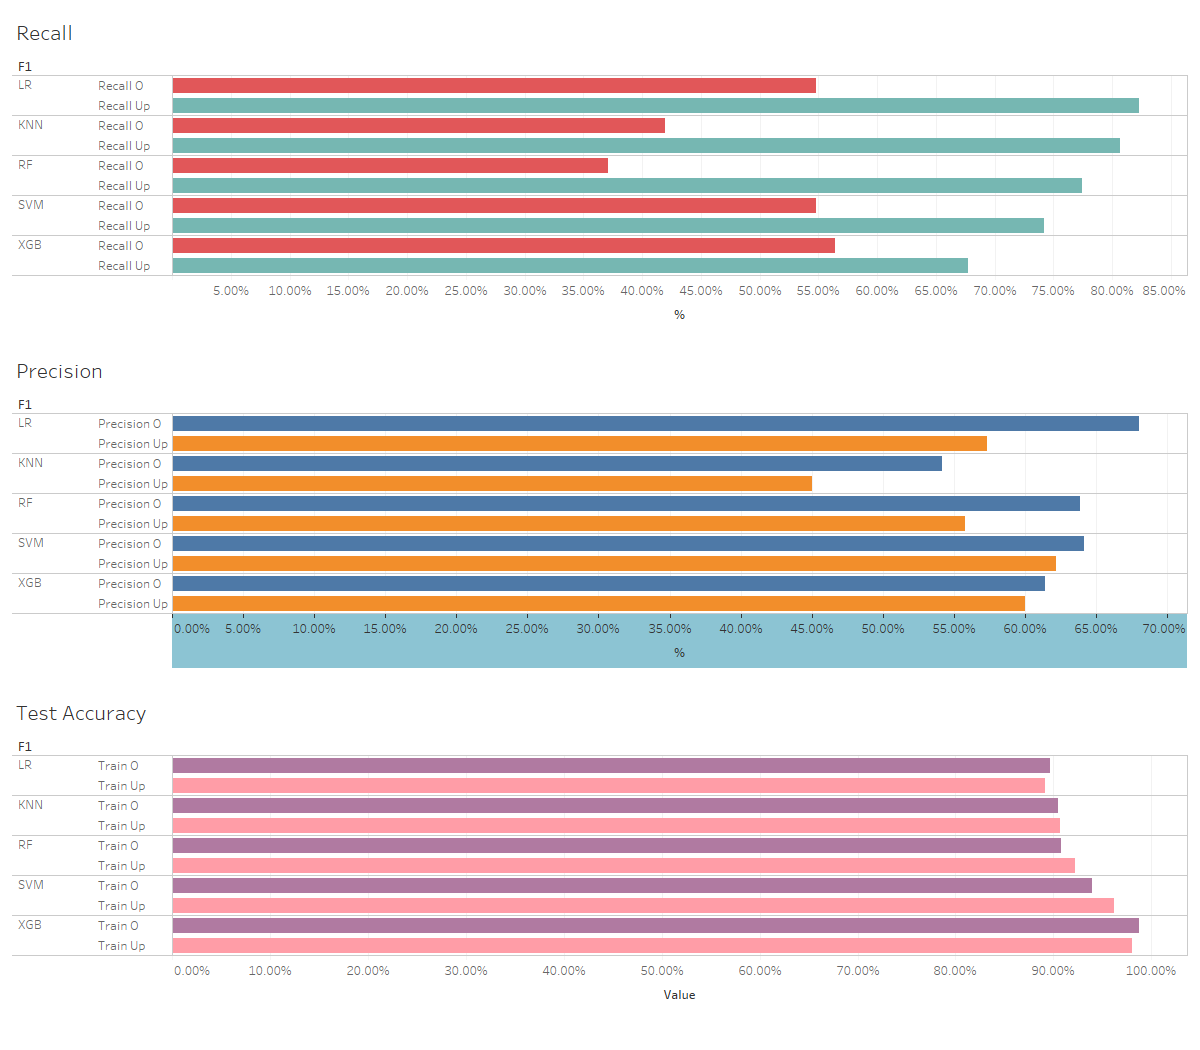

In [79]:
Image(filename = 'data/result_graph.png')

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Using Tableau, I generated these three bar graphs with original scores of Recall, Precision and Test Accuracy of different models. There is significant boost in recall score in models with upsampled data whereas tradeoff for boost in recall seem to outperform the drop in precision. I get as big as 25% boost in recall for 10% dropoff in precision. By simply introducing new data in category 1, I am feeding more category 1s for machine learning models to get far more True Positives. As models are picking out True Positives, boost in recall makes sense. In further tuning hyperparameters for these different machine learning models, I will apply SMOTE as upsampling as I see immediate jump in recall.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Through hyperparameter tuning, I hope to boost precision while staying relative to level of upsampled recall score. 

<hr style="border:2px solid gray"> </hr>

## Hyperparameter Optimization

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Now that I have base-models, working on hyper-parameter tuning. Just like I did, I will save up results so it is easy to follow when comparing different models. I will make analysis in the end. Also random_state `777` is placed for reproducibility.

In [80]:
# Again like base modelling, I will store the results for future analysis
tuned_result_df = pd.DataFrame(columns = ['train_acc', 'test_acc', 'precision', 'recall'],
                        index = ['LR', 'KNN', 'RF', 'SVM', 'XGB', 'VC'])

In [81]:
tuned_result_df

,train_acc,test_acc,precision,recall
LR,NaN,NaN,NaN,NaN
KNN,NaN,NaN,NaN,NaN
RF,NaN,NaN,NaN,NaN
SVM,NaN,NaN,NaN,NaN
XGB,NaN,NaN,NaN,NaN
VC,NaN,NaN,NaN,NaN


In [82]:
# Storage for the results
train = []
test = []
precision = []
recall = []

In [83]:
# Set the hyperparameters for a Grid Search

# I chose not to include PCA in part of Grid search as interpretability is the king for my project, especially when it comes to 

# LR model. There are not too many features and figured PCA is not really going to be fruitful
# C in 10^-3 to 10^3
params_lr = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'solver':['newton-cg', 'lbfgs', 'liblinear', 'saga'], 
             'class_weight': ['balanced', None], 'penalty' : ['l2', None], 'random_state': [777]} 

# KNN model. For metric decided to not include cosine similarity as I thought it was not useful.
# Vectors directing in similar direction do not mean those teams making playoff. Magnitude matters more it feels.
params_knn = {'n_neighbors':list(range(3,16,2)), 'weights':['uniform', 'distance'], 
              'algorithm':['auto', 'ball_tree', 'kd_tree', 'brute'], 'metric':['euclidean','minkowski']}

# RF model. Ensemble of Decision Tree. criterion is how you make the decision basis.
# max_depth of 3 as this converges quickly as well
params_rf = {'n_estimators':[10, 25, 50, 100, 150, 200], 'criterion':['gini','entropy'],
             'max_depth':list(range(1,4)), 'min_samples_leaf':[5, 9, 15, 25], 'random_state': [777]}

# SVM model. Look for decision boundary in hyperplane and maximizes the margin from tags
params_svm = {'C':[0.001, 0.01, 0.1, 1, 10, 100, 1000], 'shrinking':[True, False], 'probability':[True, False],
              'gamma':['scale','auto'], 'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'random_state': [777]}

# xgb is DT based ensemble. It makes adjustments on errors and tries to find the minimum
# Feels like xgb converges a little too quickly for my data. Maybe my data set is not large enough
# xgb max_depth < 3 = super overfit close to 100% train accuracy.
# It converged too quickly so tried to mitigate it with learning_rate
params_xgb = {'max_depth':[1, 2], 'learning_rate': [0.05, 0.1, 0.15, 0.2, 0.25], 
              'n_estimators':list(range(100, 301, 50)), 'booster':['gbtree','dart'], 'random_state': [777]}

In [84]:
# Rather than using sklearn pipeline, use imblearn package as it will handle upsampling correctly.

# This way I will avoid upsampling my validation set in cross-validation 

# Regular pipeline will upsample apply transformation (upsample) my validation set while performing cross-validation
from imblearn.pipeline import Pipeline, make_pipeline

In [85]:
# from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

### <u>Logistic Regression</u>



In [86]:
# Set up the (placeholder) pipeline 
pipeline_lr = make_pipeline(SMOTE(sampling_strategy = 1, random_state = 777, n_jobs = -1), LogisticRegression())  

In [87]:
# Set up parameters!
new_params_lr = {'logisticregression__' + key: params_lr[key] for key in params_lr}

In [88]:
new_params_lr

{'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
 'logisticregression__solver': ['newton-cg', 'lbfgs', 'liblinear', 'saga'],
 'logisticregression__class_weight': ['balanced', None],
 'logisticregression__penalty': ['l2', None],
 'logisticregression__random_state': [777]}

In [89]:
# Evaluate on 'precision'

# I also tried 'f1' and default (accuracy). 'precision' yielded best result meaning I could improve 'precision' without
# losing much on 'recall'.
grid_lr = GridSearchCV(pipeline_lr, param_grid = new_params_lr, cv = 5, n_jobs = -1, verbose = 1, scoring = 'precision')

grid_lr.fit(X_train,y_train)

Fitting 5 folds for each of 112 candidates, totalling 560 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 560 out of 560 | elapsed:   12.3s finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('smote',
                                        SMOTE(n_jobs=-1, random_state=777,
                                              sampling_strategy=1)),
                                       ('logisticregression',
                                        LogisticRegression())]),
             n_jobs=-1,
             param_grid={'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100,
                                                   1000],
                         'logisticregression__class_weight': ['balanced', None],
                         'logisticregression__penalty': ['l2', None],
                         'logisticregression__random_state': [777],
                         'logisticregression__solver': ['newton-cg', 'lbfgs',
                                                        'liblinear', 'saga']},
             scoring='precision', verbose=1)

In [90]:
# Removed pickle. Strictly was for me so I didn't have to rerun all the models coming back to work on them
# import pickle

In [91]:
# save grid_lr using Pickle
# file_lr = 'grid_lr_cov.sav'
# pickle.dump(grid_lr, open(file_lr, 'wb'))

In [92]:
# file_lr = 'grid_lr_cov.sav'
# loaded_lr = pickle.load(open(file_lr, 'rb'))

In [93]:
# See what the best hyperparameters were
grid_lr.best_params_

{'logisticregression__C': 10,
 'logisticregression__class_weight': 'balanced',
 'logisticregression__penalty': 'l2',
 'logisticregression__random_state': 777,
 'logisticregression__solver': 'newton-cg'}

In [94]:
# Train Accuracy
grid_lr_train_acc = grid_lr.best_estimator_.score(X_train, y_train)

# Test Accuracy
grid_lr_test_acc = grid_lr.best_estimator_.score(X_test, y_test)

print(f'Train accuracy: {round(grid_lr_train_acc * 100,2)}%')
print(f'Test accuracy: {round(grid_lr_test_acc * 100,2)}%')

Train accuracy: 87.04%
Test accuracy: 81.85%


In [95]:
# Classification report and ROC AUC Score
print(classification_report(y_test, grid_lr.best_estimator_.predict(X_test)))
print(f'ROC AUC Score: {round(roc_auc_score(y_test, grid_lr.best_estimator_.predict(X_test)),2)}')

              precision    recall  f1-score   support

           0       0.93      0.82      0.87       208
           1       0.57      0.81      0.67        62

    accuracy                           0.82       270
   macro avg       0.75      0.81      0.77       270
weighted avg       0.85      0.82      0.83       270

ROC AUC Score: 0.81


In [96]:
# Store best tuned LR accuracies with upsampled data
train.append(grid_lr_train_acc)
test.append(grid_lr_test_acc)

In [97]:
# Store best tuned LR precision and recall of upsampled data
precision.append(classification_report(y_test, grid_lr.best_estimator_.predict(X_test), output_dict = True)['1']['precision'])
recall.append(classification_report(y_test, grid_lr.best_estimator_.predict(X_test), output_dict = True)['1']['recall'])

### <u>KNN</u>

In [98]:
# Set up the (placeholder) pipeline 
pipeline_knn = make_pipeline(SMOTE(sampling_strategy = 1, random_state = 777, n_jobs = -1), KNeighborsClassifier())

In [99]:
new_params_knn = {'kneighborsclassifier__' + key: params_knn[key] for key in params_knn}

In [100]:
new_params_knn

{'kneighborsclassifier__n_neighbors': [3, 5, 7, 9, 11, 13, 15],
 'kneighborsclassifier__weights': ['uniform', 'distance'],
 'kneighborsclassifier__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
 'kneighborsclassifier__metric': ['euclidean', 'minkowski']}

In [101]:
grid_knn = GridSearchCV(pipeline_knn, param_grid = new_params_knn, cv = 5, n_jobs = -1, verbose = 1, scoring = 'precision')

grid_knn.fit(X_train,y_train)

Fitting 5 folds for each of 112 candidates, totalling 560 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 536 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 560 out of 560 | elapsed:    9.7s finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('smote',
                                        SMOTE(n_jobs=-1, random_state=777,
                                              sampling_strategy=1)),
                                       ('kneighborsclassifier',
                                        KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'kneighborsclassifier__algorithm': ['auto',
                                                             'ball_tree',
                                                             'kd_tree',
                                                             'brute'],
                         'kneighborsclassifier__metric': ['euclidean',
                                                          'minkowski'],
                         'kneighborsclassifier__n_neighbors': [3, 5, 7, 9, 11,
                                                               13, 15],
                         'kneighborsclassifier__weigh

In [102]:
# save grid_knn using Pickle
#file_knn = 'grid_knn_f1.sav'
#pickle.dump(grid_knn, open(file_knn, 'wb'))

In [103]:
#file_knn = 'grid_knn_f1.sav'
#loaded_knn = pickle.load(open(file_knn, 'rb'))

In [104]:
# Best hyperparameters for KNN
grid_knn.best_params_

{'kneighborsclassifier__algorithm': 'auto',
 'kneighborsclassifier__metric': 'euclidean',
 'kneighborsclassifier__n_neighbors': 3,
 'kneighborsclassifier__weights': 'uniform'}

In [105]:
# Train Accuracy
grid_knn_train_acc = grid_knn.best_estimator_.score(X_train, y_train)

# Test Accuracy
grid_knn_test_acc = grid_knn.best_estimator_.score(X_test, y_test)

print(f'Train accuracy: {round(grid_knn_train_acc * 100,2)}%')
print(f'Test accuracy: {round(grid_knn_test_acc * 100,2)}%')

Train accuracy: 89.35%
Test accuracy: 71.85%


In [106]:
# Classification report on KNN
print(classification_report(y_test, grid_knn.best_estimator_.predict(X_test)))
print('ROC AUC Score: %.2f' % roc_auc_score(y_test, grid_knn.best_estimator_.predict(X_test)))

              precision    recall  f1-score   support

           0       0.91      0.70      0.79       208
           1       0.44      0.77      0.56        62

    accuracy                           0.72       270
   macro avg       0.67      0.74      0.68       270
weighted avg       0.80      0.72      0.74       270

ROC AUC Score: 0.74


In [107]:
# Store best tuned KNN accuracies with upsampled data
train.append(grid_knn_train_acc)
test.append(grid_knn_test_acc)

In [108]:
# Store best tuned KNN precision and recall of upsampled data
precision.append(classification_report(y_test, grid_knn.best_estimator_.predict(X_test), output_dict = True)['1']['precision'])
recall.append(classification_report(y_test, grid_knn.best_estimator_.predict(X_test), output_dict = True)['1']['recall'])

### <u>Random Forest</u>

In [109]:
# Set up the pipeline 
pipeline_rf = make_pipeline(SMOTE(sampling_strategy = 1, random_state = 777, n_jobs = -1), RandomForestClassifier())

In [110]:
# Set up parameters!
new_params_rf = {'randomforestclassifier__' + key: params_rf[key] for key in params_rf}

In [111]:
grid_rf = GridSearchCV(pipeline_rf, param_grid = new_params_rf, cv = 5, n_jobs = -1, verbose = 1, scoring = 'precision')

grid_rf.fit(X_train, y_train)

Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  73 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:   26.1s
[Parallel(n_jobs=-1)]: Done 474 tasks      | elapsed:   53.6s
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed:  1.5min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('smote',
                                        SMOTE(n_jobs=-1, random_state=777,
                                              sampling_strategy=1)),
                                       ('randomforestclassifier',
                                        RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'randomforestclassifier__criterion': ['gini',
                                                               'entropy'],
                         'randomforestclassifier__max_depth': [1, 2, 3],
                         'randomforestclassifier__min_samples_leaf': [5, 9, 15,
                                                                      25],
                         'randomforestclassifier__n_estimators': [10, 25, 50,
                                                                  100, 150,
                                                                  200],
                         'ran

In [112]:
# save grid_rf using Pickle
#file_rf = 'grid_rf_cov.sav'
#pickle.dump(grid_rf, open(file_rf, 'wb'))

In [113]:
#file_rf = 'grid_rf_cov.sav'
#loaded_rf = pickle.load(open(file_rf, 'rb'))

In [114]:
# Best parameters for Random Forest!
grid_rf.best_params_

{'randomforestclassifier__criterion': 'gini',
 'randomforestclassifier__max_depth': 3,
 'randomforestclassifier__min_samples_leaf': 5,
 'randomforestclassifier__n_estimators': 50,
 'randomforestclassifier__random_state': 777}

In [115]:
# Train Accuracy
grid_rf_train_acc = grid_rf.best_estimator_.score(X_train, y_train)

# Test Accuracy
grid_rf_test_acc = grid_rf.best_estimator_.score(X_test, y_test)

print(f'Train accuracy: {round(grid_rf_train_acc * 100,2)}%')
print(f'Test accuracy: {round(grid_rf_test_acc * 100,2)}%')

Train accuracy: 86.2%
Test accuracy: 80.37%


In [116]:
# Classification Report
print(classification_report(y_test, grid_rf.best_estimator_.predict(X_test)))
print(f'ROC AUC Score: {round(roc_auc_score(y_test, grid_rf.best_estimator_.predict(X_test)),2)}')

              precision    recall  f1-score   support

           0       0.93      0.81      0.86       208
           1       0.55      0.79      0.65        62

    accuracy                           0.80       270
   macro avg       0.74      0.80      0.76       270
weighted avg       0.84      0.80      0.81       270

ROC AUC Score: 0.8


In [117]:
# Store best tuned RF accuracies with upsampled data
train.append(grid_rf_train_acc)
test.append(grid_rf_test_acc)

In [118]:
# Store best tuned RF precision and recall of upsampled data
precision.append(classification_report(y_test, grid_rf.best_estimator_.predict(X_test), output_dict = True)['1']['precision'])
recall.append(classification_report(y_test, grid_rf.best_estimator_.predict(X_test), output_dict = True)['1']['recall'])

### <u>Support Vector Machines</u>

In [119]:
# Set up the (placeholder) pipeline 
pipeline_svm = make_pipeline(SMOTE(sampling_strategy = 1, random_state = 777, n_jobs = -1),
                         SVC())

In [120]:
# Set up parameters!
new_params_svm = {'svc__' + key: params_svm[key] for key in params_svm}

In [121]:
# I used f1 for parameter scoring here as scoring on best precision gave only 1% increase to 0.60 in precision whereas 

# recall suffered heavily with almost 20% drop. I made judgement call that it was not worth the trade-off
grid_svm = GridSearchCV(pipeline_svm, param_grid = new_params_svm, cv = 5, n_jobs = -1, verbose = 1, scoring = 'f1')

grid_svm.fit(X_train,y_train)

Fitting 5 folds for each of 224 candidates, totalling 1120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-1)]: Done 676 tasks      | elapsed:   48.1s
[Parallel(n_jobs=-1)]: Done 1036 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 1120 out of 1120 | elapsed:  6.0min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('smote',
                                        SMOTE(n_jobs=-1, random_state=777,
                                              sampling_strategy=1)),
                                       ('svc', SVC())]),
             n_jobs=-1,
             param_grid={'svc__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'svc__gamma': ['scale', 'auto'],
                         'svc__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                         'svc__probability': [True, False],
                         'svc__random_state': [777],
                         'svc__shrinking': [True, False]},
             scoring='f1', verbose=1)

In [122]:
# save grid_svm using Pickle
#file_svm = 'grid_svm_cov.sav'
#pickle.dump(grid_svm, open(file_svm, 'wb'))

In [123]:
#file_svm = 'grid_svm_cov.sav'
#loaded_svm = pickle.load(open(file_svm, 'rb'))

In [124]:
# Best parameters for Support Vector Machine!
grid_svm.best_params_

{'svc__C': 100,
 'svc__gamma': 'auto',
 'svc__kernel': 'rbf',
 'svc__probability': True,
 'svc__random_state': 777,
 'svc__shrinking': True}

In [125]:
# Train Accuracy
grid_svm_train_acc = grid_svm.best_estimator_.score(X_train, y_train)

# Test Accuracy
grid_svm_test_acc = grid_svm.best_estimator_.score(X_test, y_test)

print(f'Train accuracy: {round(grid_svm_train_acc * 100,2)}%')
print(f'Test accuracy: {round(grid_svm_test_acc * 100,2)}%')

Train accuracy: 92.31%
Test accuracy: 82.59%


In [126]:
# Classification report on SVM
print(classification_report(y_test, grid_svm.best_estimator_.predict(X_test)))
print(f'ROC AUC Score: {round(roc_auc_score(y_test, grid_svm.best_estimator_.predict(X_test)),2)}')

              precision    recall  f1-score   support

           0       0.92      0.85      0.88       208
           1       0.59      0.76      0.67        62

    accuracy                           0.83       270
   macro avg       0.76      0.80      0.77       270
weighted avg       0.85      0.83      0.83       270

ROC AUC Score: 0.8


In [127]:
# Store best tuned SVM accuracies with upsampled data
train.append(grid_svm_train_acc)
test.append(grid_svm_test_acc)

In [128]:
# Store best tuned SVM precision and recall of upsampled data
precision.append(classification_report(y_test, grid_svm.best_estimator_.predict(X_test), output_dict = True)['1']['precision'])
recall.append(classification_report(y_test, grid_svm.best_estimator_.predict(X_test), output_dict = True)['1']['recall'])

### <u>Extreme Gradient Boost</u>

In [129]:
# Set up the pipeline 
pipeline_xgb = make_pipeline(SMOTE(sampling_strategy = 1, random_state = 777, n_jobs = -1),
                         XGBClassifier())

In [130]:
# Set up parameters!
new_params_xgb = {'xgbclassifier__' + key: params_xgb[key] for key in params_xgb}

In [131]:
new_params_xgb

{'xgbclassifier__max_depth': [1, 2],
 'xgbclassifier__learning_rate': [0.05, 0.1, 0.15, 0.2, 0.25],
 'xgbclassifier__n_estimators': [100, 150, 200, 250, 300],
 'xgbclassifier__booster': ['gbtree', 'dart'],
 'xgbclassifier__random_state': [777]}

In [132]:
# Grid search with my parameters
grid_xgb = GridSearchCV(pipeline_xgb, param_grid = new_params_xgb, cv = 5, n_jobs = -1, verbose = 1, scoring = 'precision')

grid_xgb.fit(X_train,y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   22.4s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.7min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('smote',
                                        SMOTE(n_jobs=-1, random_state=777,
                                              sampling_strategy=1)),
                                       ('xgbclassifier',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      gamma=None, gpu_id=None,
                                                      importance_type='gain',
                                                      interaction_constraints=None,
                                                      learning_rate=None,
                                             

In [133]:
# Save grid_xgb using Pickle
#file_xgb = 'grid_xgb_cov.sav'
#pickle.dump(grid_xgb, open(file_xgb, 'wb'))

In [134]:
#file_xgb = 'grid_xgb_cov.sav'
#loaded_xgb = pickle.load(open(file_xgb, 'rb'))

In [135]:
# Best parameters for Extreme Gradient Boost!
grid_xgb.best_params_

{'xgbclassifier__booster': 'gbtree',
 'xgbclassifier__learning_rate': 0.2,
 'xgbclassifier__max_depth': 2,
 'xgbclassifier__n_estimators': 150,
 'xgbclassifier__random_state': 777}

In [136]:
# Train Accuracy
grid_xgb_train_acc = grid_xgb.best_estimator_.score(X_train, y_train)

# Test Accuracy
grid_xgb_test_acc = grid_xgb.best_estimator_.score(X_test, y_test)

print(f'Train accuracy: {round(grid_xgb_train_acc * 100,2)}%')
print(f'Test accuracy: {round(grid_xgb_test_acc * 100,2)}%')

Train accuracy: 97.04%
Test accuracy: 82.22%


In [137]:
print(classification_report(y_test, grid_xgb.best_estimator_.predict(X_test)))
print(f'ROC AUC Score: {round(roc_auc_score(y_test, grid_xgb.best_estimator_.predict(X_test)),2)}')

              precision    recall  f1-score   support

           0       0.90      0.87      0.88       208
           1       0.60      0.68      0.64        62

    accuracy                           0.82       270
   macro avg       0.75      0.77      0.76       270
weighted avg       0.83      0.82      0.83       270

ROC AUC Score: 0.77


In [138]:
# Store best tuned XGB accuracies with upsampled data
train.append(grid_xgb_train_acc)
test.append(grid_xgb_test_acc)

In [139]:
# Store best tuned LR precision and recall of upsampled data
precision.append(classification_report(y_test, grid_xgb.best_estimator_.predict(X_test), output_dict = True)['1']['precision'])
recall.append(classification_report(y_test, grid_xgb.best_estimator_.predict(X_test), output_dict = True)['1']['recall'])

### <u>Voting Classifier</u>

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;I had one big choice to make with vote parameter. Default is hard vote and I elect to use the default over soft vote.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Hard vote chooses the majority outcome whereas soft vote chooses class with most certainty. Since performances in five models earlier were similar I figured aggregating in hard vote makes more sense as I have binary outcome and odd number of sub-models.

In [140]:
from sklearn.ensemble import VotingClassifier

In [141]:
# Prepare voting classifier with best tuned sub-models previously
vc = VotingClassifier(estimators = [('lr', grid_lr.best_estimator_), ('knn', grid_knn.best_estimator_),
                                    ('rf', grid_rf.best_estimator_), ('svm', grid_svm.best_estimator_),
                                    ('xgb', grid_xgb.best_estimator_)])

In [142]:
vc.fit(X_train, y_train)

VotingClassifier(estimators=[('lr',
                              Pipeline(steps=[('smote',
                                               SMOTE(n_jobs=-1,
                                                     random_state=777,
                                                     sampling_strategy=1)),
                                              ('logisticregression',
                                               LogisticRegression(C=10,
                                                                  class_weight='balanced',
                                                                  random_state=777,
                                                                  solver='newton-cg'))])),
                             ('knn',
                              Pipeline(steps=[('smote',
                                               SMOTE(n_jobs=-1,
                                                     random_state=777,
                                                     sampling_

In [143]:
vc.estimators_

[Pipeline(steps=[('smote',
                  SMOTE(n_jobs=-1, random_state=777, sampling_strategy=1)),
                 ('logisticregression',
                  LogisticRegression(C=10, class_weight='balanced',
                                     random_state=777, solver='newton-cg'))]),
 Pipeline(steps=[('smote',
                  SMOTE(n_jobs=-1, random_state=777, sampling_strategy=1)),
                 ('kneighborsclassifier',
                  KNeighborsClassifier(metric='euclidean', n_neighbors=3))]),
 Pipeline(steps=[('smote',
                  SMOTE(n_jobs=-1, random_state=777, sampling_strategy=1)),
                 ('randomforestclassifier',
                  RandomForestClassifier(max_depth=3, min_samples_leaf=5,
                                         n_estimators=50, random_state=777))]),
 Pipeline(steps=[('smote',
                  SMOTE(n_jobs=-1, random_state=777, sampling_strategy=1)),
                 ('svc',
                  SVC(C=100, gamma='auto', probability=Tru

In [144]:
# Train Accuracy
vc_train_acc = vc.score(X_train_up, y_train_up)

# Test Accuracy
vc_test_acc =vc.score(X_test, y_test)

print(f'Train accuracy: {round(vc_train_acc * 100,2)}%')
print(f'Test accuracy: {round(vc_test_acc * 100,2)}%')

Train accuracy: 94.53%
Test accuracy: 82.22%


In [145]:
print(classification_report(y_test, vc.predict(X_test)))

print(f'ROC AUC Score: {round(roc_auc_score(y_test, vc.predict(X_test)),2)}')

              precision    recall  f1-score   support

           0       0.92      0.85      0.88       208
           1       0.59      0.74      0.66        62

    accuracy                           0.82       270
   macro avg       0.75      0.79      0.77       270
weighted avg       0.84      0.82      0.83       270

ROC AUC Score: 0.79


In [146]:
# Store best tuned VC accuracies with upsampled data
train.append(vc_train_acc)
test.append(vc_test_acc)

In [147]:
# Store best tuned LR precision and recall of upsampled data
precision.append(classification_report(y_test, vc.predict(X_test), output_dict = True)['1']['precision'])
recall.append(classification_report(y_test, vc.predict(X_test), output_dict = True)['1']['recall'])

In [148]:
# Add the stored results for analysis
tuned_result_df['train_acc'] = train
tuned_result_df['test_acc'] = test
tuned_result_df['precision'] = precision
tuned_result_df['recall'] = recall

In [149]:
tuned_result_df

,train_acc,test_acc,precision,recall
LR,0.870370,0.818519,0.574713,0.806452
KNN,0.893519,0.718519,0.436364,0.774194
RF,0.862037,0.803704,0.550562,0.790323
SVM,0.923148,0.825926,0.594937,0.758065
XGB,0.970370,0.822222,0.600000,0.677419
VC,0.945312,0.822222,0.589744,0.741935


&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;I will plot AUC-ROC curve. It is another evaluation metric. AUC is area under the curve and is the measurement of ability of a classifer to dinstinguish classes. ROC is receiver operator characteristic and is a probability curve that plots True Positive Rate against False Positive Rate at different thresholds. Along with tuned_result_df, it will help me determine which model performed the best.

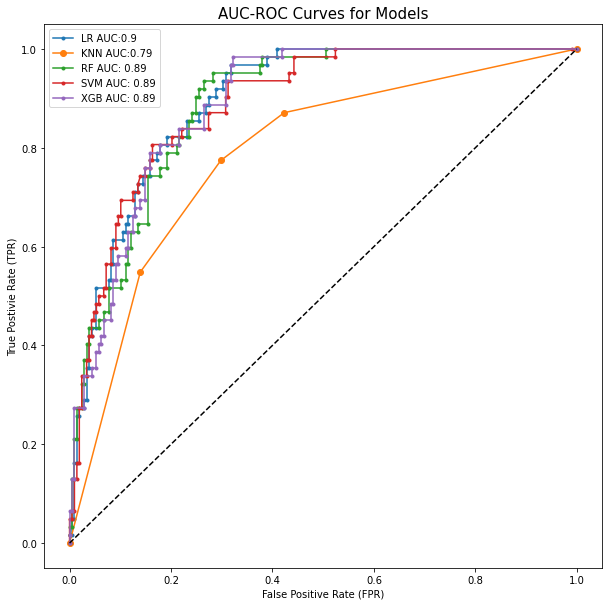

In [150]:
# For ROC / AUC need the probability scores (for the positive class)
# Voting classifier is not here as it does not have predict_proba when it is in hard vote
from sklearn.metrics import roc_curve

# Predict the probabilities
y_lr = grid_lr.best_estimator_.predict_proba(X_test)[:, 1]
y_knn = grid_knn.best_estimator_.predict_proba(X_test)[:, 1]
y_rf = grid_rf.best_estimator_.predict_proba(X_test)[:, 1]
y_svm = grid_svm.best_estimator_.predict_proba(X_test)[:, 1]
y_xgb = grid_xgb.best_estimator_.predict_proba(X_test)[:, 1]

# Calculate the thresholds, fprs, and tprs
fpr1, tpr1, thresholds1 = roc_curve(y_test, y_lr)
fpr2, tpr2, thresholds2 = roc_curve(y_test, y_knn)
fpr3, tpr3, thresholds3 = roc_curve(y_test, y_rf)
fpr4, tpr4, thresholds4 = roc_curve(y_test, y_svm)
fpr5, tpr5, thresholds5 = roc_curve(y_test, y_xgb)

# Calculate AUCs
lr_auc = roc_auc_score(y_test, y_lr)
knn_auc = roc_auc_score(y_test, y_knn)
rf_auc = roc_auc_score(y_test, y_rf)
svm_auc = roc_auc_score(y_test, y_svm) 
xgb_auc = roc_auc_score(y_test, y_xgb) 


# Plot the ROC curves for each
plt.figure(figsize = (10,10))
plt.plot(fpr1, tpr1, label=f'LR AUC:{np.around(lr_auc ,2)}', marker='.')
plt.plot(fpr2, tpr2, label=f'KNN AUC:{np.around(knn_auc,2)}', marker='o')
plt.plot(fpr3, tpr3, label=f'RF AUC: {np.around(rf_auc,2)}', marker='.')
plt.plot(fpr4, tpr4, label=f'SVM AUC: {np.around(svm_auc,2)}', marker='.')
plt.plot(fpr5, tpr5, label=f'XGB AUC: {np.around(xgb_auc,2)}', marker='.')

# Reference line
plt.plot([0,1],[0,1], color='black', linestyle='--')
plt.legend()
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Postivie Rate (TPR)')
plt.title('AUC-ROC Curves for Models', fontsize = 15)
plt.show()

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;It is extremely disappointing to see there was no real improvement in precision which I was hoping to find doing hyperparameter optimization. I suspect this low precision is due to limitation of data. KNN performed worst in precision and this tells me it is having extra difficult time solid boundary. There is probably alot of ambiguous cases for KNN to perform as the model looks at a number of different points to come up with decisions and I can see why KNN struggels the most. Only four teams made the MLB playoff before expansion in 1995 which is about half of my data. Current format takes in ten teams so models have hard time setting the boundaries as some teams from pre-expansion of playoff would be shoe in to the playoff but due to the harsh format, they did not. Because of this, there is very strong uncertainty in boundaries leading to almost 'crap shoot'.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;AUC-ROC tells similar story. All the models but KNN are performing on par. KNN is slightly underperforming and I think what I just wrote earlier is the cause for it. 

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Before diving in deeper, I'd like to share brief background information on expansions of MLB playoff. Pre-expansion from 1969 to 1993, only four teams made the playoff. First expansion took place in 1995, right after players' strike cancelled 1994 playoff, with introduction of wildcard format and brought the number to eight teams. Second expansion took place in 2012 and total number of teams making playoff to ten. I hope you can see why I am blaming low precision on data as well. These different formats cause very ambiguous boundary cases for models to predict on. Some teams that might have made playoff easily might not make the playoff purely due to the format of the playoff.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;I will take on following to further inspect what is happening and causing such low precisions:

* I will move threshold to see if I could maximize precision and recall in class 1. 

* I will inspect the False Positive data points and see where they are from. If majority come from pre-expansion of playoff, I can change the data I modelled on.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;I will carry on with best model for Logistic Regression though SVM has competing performance as well. LR and SVM have similar AUCs and ROCs almost overlap. Not significant difference is visible on result df as well. It is personal choice really as LR is a bit more interpretable for my taste.

<hr style="border:2px solid gray"> </hr>

## Analysis for Cause of Low Precision in Category 1

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;I will start off by analyzing if there is a threshold that maximizes both recall and precision. Then I will inspect False Positives so I understand what happened in those.

In [151]:
# This is predicted probability in test set
y_proba = grid_lr.best_estimator_.predict_proba(X_test)[:,1]

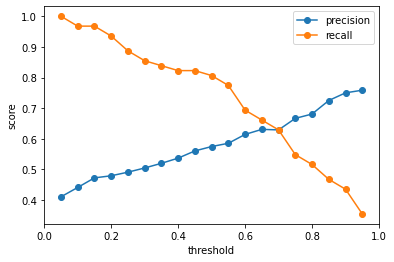

In [152]:
# Import necessary packages
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

# Vary thresholds by 0.05 from 0.05 to 0.95
thresholds = np.arange(0.05, 1, 0.05)

# Storing precisions and recalls in lists for plotting later
precisions = list()
recalls = list()

# Loop to find in order to maximize the precision and recall by adjusting threshold
for threshold in thresholds:

    # Apply threshold and 'predict' using the adjusted threshold
    y_threshold = np.where(y_proba > threshold, 1, 0)
    
    # Calculate precision and recall. Added _graph in variable name as I am using precision and recall for something else
    precision_graph = precision_score(y_test, y_threshold)
    recall_graph = recall_score(y_test, y_threshold)
    
    # Append to list for visualization
    precisions.append(precision_graph)
    recalls.append(recall_graph)

# Visualize the result
plt.figure()
plt.plot(thresholds, precisions, label='precision', marker='o')
plt.plot(thresholds, recalls, label='recall', marker='o')
plt.xlim(0, 1)
plt.xlabel('threshold')
plt.ylabel('score')
plt.legend()
plt.show()

In [153]:
# This is precision and recall for default threshold at 0.5
precisions[9], recalls[9]

(0.5747126436781609, 0.8064516129032258)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;With current threshold at 0.5 I have precision of 0.57 and recall of 0.81 for class 1, teams in playoff. I do not think I can justify adjusting threshold to maximize the precision. There is big drop-off in recall and it essentially erase the boost in recall that I got from upsampling. I will carry on with examples are predicted as 1 but in actual 0, False Positives.

In [154]:
# Empty dataframe. Strictly there as a placeholder so when I run multiple times, I instantiate a empty dataframe
lr_analysis = pd.DataFrame()

# Creating dataframe for analysis. First column with 'playoff_appearance'
lr_analysis['playoff_appearance'] = y_test

In [155]:
# Variable for outcomes of X_test
y_pred = grid_lr.best_estimator_.predict(X_test)

In [156]:
# Adding two columns with 'prediction' and 'predicted_proba'
lr_analysis['prediction'] = y_pred
lr_analysis['predicted_proba'] = y_proba

In [157]:
# Merge 'team' and 'year' column from df_scaled
lr_analysis = lr_analysis.merge(df_scaled.iloc[:,-3:-1], left_index = True, right_index = True)

In [158]:
# See how many rows are either False Positive or False Negative
len(lr_analysis[lr_analysis['prediction'] != lr_analysis['playoff_appearance']])

49

In [159]:
# Test set with prediction and prediction_proba
lr_analysis

,playoff_appearance,prediction,predicted_proba,team,year
146,1,1,5.550318e-01,BOS,1975
834,1,1,7.504633e-01,STL,2000
582,1,1,9.529258e-01,ATL,1992
356,0,1,7.080318e-01,DET,1983
1000,0,0,7.389651e-06,KCR,2006
...,...,...,...,...,...
303,0,0,6.661934e-03,CLE,1981
192,0,0,1.245821e-04,ATL,1977
44,0,0,2.329376e-04,SDP,1970
269,0,0,6.049572e-07,TOR,1979


In [160]:
# These are rows that are predicted 1 and in actual 0, False Positives. I want to dive deeper on these
rows_of_interest = lr_analysis[(lr_analysis['prediction'] == 1) & (lr_analysis['playoff_appearance'] == 0)]

In [161]:
# Number of FP
len(rows_of_interest)

37

In [162]:
# Have a look. Want to further divide them up by years pre-expansion and post-expansion (pre and post 1994)
rows_of_interest

,playoff_appearance,prediction,predicted_proba,team,year
356,0,1,0.708032,DET,1983
863,0,1,0.917755,SFG,2001
1001,0,1,0.807221,LAA,2006
467,0,1,0.988768,NYM,1987
545,0,1,0.971050,NYM,1990
464,0,1,0.778337,MIL,1987
136,0,1,0.749236,NYY,1974
477,0,1,0.998637,TOR,1987
567,0,1,0.732430,LAD,1991
120,0,1,0.972974,ATL,1974


In [163]:
# Number of rows with prediction 1
(lr_analysis['prediction'] == 1).sum()

87

In [164]:
# Manual calculation of Precision for sanity check =]
1-37/87

0.5747126436781609

In [165]:
len(rows_of_interest[rows_of_interest['year'] < 1994]), len(rows_of_interest[rows_of_interest['year'] > 1994])

(24, 13)

In [166]:
24 / (24+13)

0.6486486486486487

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;About 65% of False Positive is coming from pre-expansion of playoff. Will break down the rows_of_interest df by years

In [167]:
# pre and post expansion dataframe from rows_of_interest
pre_expansion = rows_of_interest[rows_of_interest['year'] < 1994]
post_expansion = rows_of_interest[rows_of_interest['year'] > 1994]

In [168]:
pre_expansion.sort_values('predicted_proba', ascending = False)

,playoff_appearance,prediction,predicted_proba,team,year
477,0,1,0.998637,TOR,1987
126,0,1,0.996922,CIN,1974
467,0,1,0.988768,NYM,1987
216,0,1,0.975378,TEX,1977
120,0,1,0.972974,ATL,1974
545,0,1,0.971050,NYM,1990
211,0,1,0.892026,PIT,1977
76,0,1,0.882179,CHC,1972
588,0,1,0.822926,CIN,1992
83,0,1,0.816513,LAD,1972


&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;These are what I call 'sure bets' with 97%+ probability yet are false positives

87 TOR (96 - 66) : Second best team in the league but divisional rival DET topped the league and divison so did not make it. I'd call them a victim of format

74 CIN (98 - 64) : Again second best team in the league with 98 wins but LAD topped the divison and league with 102 wins. Again a victim of format

87 NYM (92 - 70) : Yet again, second best team in the league with 92 wins. Another victim of format

77 TEX (94 - 68) : Second in division... You know what happened by now right? 

90 NYM (91 - 71) : Second best team in the league and division. Another victim of format

77 PIT (96 - 66) : Third best team in the league and division. All of these teams I listed above would surely make into playoff in current format

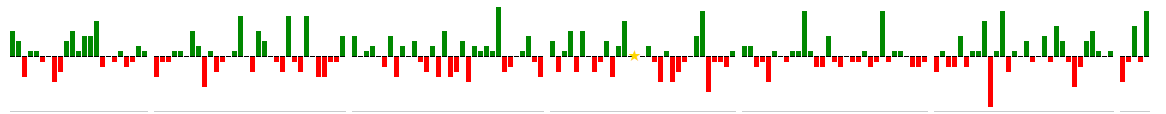

In [169]:
# Margin of victory for 86 SFG
Image(filename = 'data/86_SFG_margin.png')

86 SFG (83 - 79) : They won big and lost by little so led to inflated features. Of course then inflated the prediction probability as well. 

In [170]:
post_expansion.sort_values('predicted_proba', ascending = False)

,playoff_appearance,prediction,predicted_proba,team,year
1194,0,1,0.973470,TBR,2012
1130,0,1,0.944975,SDP,2010
863,0,1,0.917755,SFG,2001
882,0,1,0.833005,LAD,2002
1001,0,1,0.807221,LAA,2006
1209,0,1,0.713166,KCR,2013
1079,0,1,0.711581,ATL,2009
956,0,1,0.642837,TEX,2004
922,0,1,0.589690,SEA,2003
715,0,1,0.577514,SEA,1996


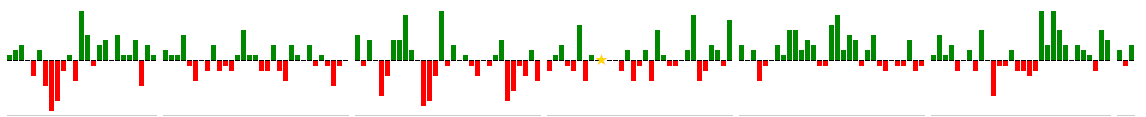

In [171]:
# Margin of victory for 12 TBR
Image(filename = 'data/12_TBR_margin.png')

12 TBR (90 - 72) : Another team had inflated probability. Very strong pitching so did not lose big

10 SDP (90 - 72) : Missed the wildcard spot by 1 win. They would be in playoff if it were current 10 team playoff format. It was 8 team playoff format

01 SFG (90 - 72) : Same story as above 10 SDP

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;I think my analysis brought some light to the limitations of data I collected. My data does not account for the format of playoff. Many teams in pre-expansion are victims of very difficult playoff format. Also my data does not account for the margin of victories. Some teams win big and lose by only little. This causes inflation on features hence inflating the predicted probabilities. In order to combat these, I could add in division information and limit how many teams can make the playoff given year so model does not predict 1 just because the predicted probability is over the threshold 0.5. 

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;For now, I will try to model with post expansion data and eliminate old data if this improves my precision for class 1. I will carry this out on logistic regression only.

In [204]:
# Getting rid of all data prior to 1994

# X2 is data from 1995 to 2020
X2 = df_scaled.loc[df_scaled['year'] > 1994].iloc[:,:-3]

# y is the playoff_appearance
y2 = df_scaled['playoff_appearance'].loc[df_scaled['year'] > 1994]

In [214]:
# Need to get rid of year 2019 and 2020
X2 = X2.loc[df_scaled['year'] < 2019]

# Last two years. That is last 60 entries of y2
y2 = y2[:-60]

In [217]:
# Split like how I did at the beginning
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, random_state = 5, stratify= y2, test_size=0.2)

In [218]:
# Set up the (placeholder) pipeline 
pipeline_lr = make_pipeline(SMOTE(sampling_strategy = 1, random_state = 777, n_jobs = -1), LogisticRegression())  

In [219]:
# Set up parameters!
new_params_lr = {'logisticregression__' + key: params_lr[key] for key in params_lr}

In [220]:
new_params_lr

{'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
 'logisticregression__solver': ['newton-cg', 'lbfgs', 'liblinear', 'saga'],
 'logisticregression__class_weight': ['balanced', None],
 'logisticregression__penalty': ['l2', None],
 'logisticregression__random_state': [777]}

In [221]:
# Evaluate on 'precision'

# I also tried 'f1' and default (accuracy). 'precision' yielded best result meaning I could improve 'precision' without
# losing much on 'recall'.
grid_lr_new = GridSearchCV(pipeline_lr, param_grid = new_params_lr, cv = 5, n_jobs = -1, verbose = 1, scoring = 'precision')

grid_lr_new.fit(X_train2,y_train2)

Fitting 5 folds for each of 112 candidates, totalling 560 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 560 out of 560 | elapsed:    9.7s finished
C:\Users\DK\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('smote',
                                        SMOTE(n_jobs=-1, random_state=777,
                                              sampling_strategy=1)),
                                       ('logisticregression',
                                        LogisticRegression())]),
             n_jobs=-1,
             param_grid={'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100,
                                                   1000],
                         'logisticregression__class_weight': ['balanced', None],
                         'logisticregression__penalty': ['l2', None],
                         'logisticregression__random_state': [777],
                         'logisticregression__solver': ['newton-cg', 'lbfgs',
                                                        'liblinear', 'saga']},
             scoring='precision', verbose=1)

In [222]:
# See what the best hyperparameters were
grid_lr_new.best_params_

{'logisticregression__C': 100,
 'logisticregression__class_weight': 'balanced',
 'logisticregression__penalty': 'l2',
 'logisticregression__random_state': 777,
 'logisticregression__solver': 'saga'}

In [223]:
# Train Accuracy
grid_lr_new_train_acc = grid_lr_new.best_estimator_.score(X_train2, y_train2)

# Test Accuracy
grid_lr_new_test_acc = grid_lr_new.best_estimator_.score(X_test2, y_test2)

print(f'Train accuracy: {round(grid_lr_new_train_acc * 100,2)}%')
print(f'Test accuracy: {round(grid_lr_new_test_acc * 100,2)}%')

Train accuracy: 88.27%
Test accuracy: 84.62%


In [224]:
# Classification report and ROC AUC Score
print(classification_report(y_test2, grid_lr_new.best_estimator_.predict(X_test2)))
print(f'ROC AUC Score: {round(roc_auc_score(y_test2, grid_lr_new.best_estimator_.predict(X_test2)),2)}')

              precision    recall  f1-score   support

           0       0.93      0.84      0.89       102
           1       0.69      0.85      0.76        41

    accuracy                           0.85       143
   macro avg       0.81      0.85      0.82       143
weighted avg       0.86      0.85      0.85       143

ROC AUC Score: 0.85


&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;With same parameter, I managed to boost precision in category 1 to 0.69 while improving recall as well to 0.85. This is very good sign as I was not able to even break 0.6 mark for precisions. By getting rid of pre-expansion data, those data points that did not make playoff back then but would be sure bet in modern MLB playoff format are gone hence the improvement in precision. Removing almost half the data is worrying but I could not come up with reasonable improvements within the time with other methods I tried like BoarderlineSMOTE. To further bring up the precision, I'd need to make further modifications in my models. However, for now, the process to bring up precision stops here. 

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;As the last step of the project, I will make prediction on unseen data I put aside at the very beginning. Will compare two predictions, one with all data from 1969 to 2018  and another with data from 1995 to 2018 (only post expansion of MLB playoff). I will have a look at change in prediction probabilities.

<hr style="border:2px solid gray"> </hr>

## Prediction on Unseen Data

In [225]:
### On Full Data

# First prepare new df with prediction probabilities
pred_2019 = pd.DataFrame(grid_lr.best_estimator_.predict_proba(X_2019)[:,1], columns = ['predicted_proba'])

In [226]:
# Add in team column
pred_2019['team'] = df_scaled[df_scaled['year'] == 2019]['team'].reset_index().drop(columns = 'index')

In [227]:
# Prediction column
pred_2019['prediction'] = grid_lr.best_estimator_.predict(X_2019)

In [228]:
# Actual playoff data
pred_2019['playoff_appearance'] = y_2019.values

In [229]:
# Sort in order
pred_2019 = pred_2019.sort_values('predicted_proba', ascending = False)

In [230]:
pred_2019

,predicted_proba,team,prediction,playoff_appearance
10,9.999644e-01,HOU,1,1
13,9.994589e-01,LAD,1,1
16,9.946273e-01,MIN,1,1
18,9.945864e-01,NYY,1,1
19,9.855965e-01,OAK,1,1
26,9.743597e-01,TBR,1,1
29,9.700079e-01,WAS,1,1
25,9.544982e-01,STL,1,1
7,9.352581e-01,CLE,1,0
1,9.248097e-01,ATL,1,1


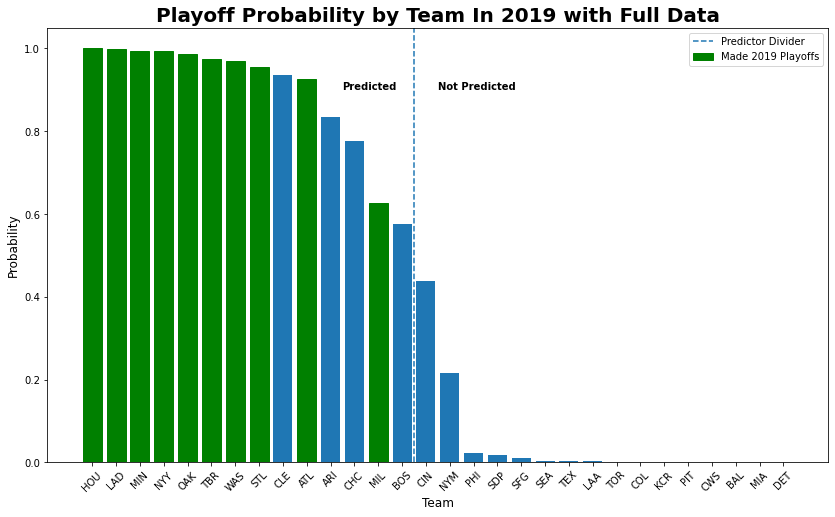

In [231]:
ax = plt.figure(figsize = (14, 8))

ax = plt.bar(pred_2019['team'], pred_2019['predicted_proba'])

# color the ones in 1, made playoff, green
for i in range(30):
    if pred_2019['playoff_appearance'].reset_index(drop = True)[i] == 1:
        ax[i].set_color('g')
        
# Add a divider       
plt.axvline(13.5, linestyle='dashed')
plt.text(10.5, 0.9, s = 'Predicted', fontweight = 'bold')
plt.text(14.5, 0.9, s = 'Not Predicted', fontweight = 'bold')
plt.legend(labels = ['Predictor Divider', 'Made 2019 Playoffs'])
        
plt.title('Playoff Probability by Team In 2019 with Full Data', fontweight='bold', fontsize=20)
plt.ylabel('Probability', fontsize = 12)
plt.xlabel('Team', fontsize = 12)
plt.xticks(rotation = 45)
plt.show()

In [232]:
### Repeat with Post expansion data only ###

pred_2019_post_exp = []

In [233]:
# First prepare new df with prediction probabilities
pred_2019_post_exp = pd.DataFrame(grid_lr_new.best_estimator_.predict_proba(X_2019)[:,1], columns = ['predicted_proba'])

In [234]:
# Add in team column
pred_2019_post_exp['team'] = df_scaled[df_scaled['year'] == 2019]['team'].reset_index().drop(columns = 'index')

In [235]:
# Prediction column
pred_2019_post_exp['prediction'] = grid_lr_new.best_estimator_.predict(X_2019)

In [236]:
# Actual playoff data
pred_2019_post_exp['playoff_appearance'] = y_2019.values

In [237]:
# Sort in order
pred_2019_post_exp = pred_2019_post_exp.sort_values('predicted_proba', ascending = False)

In [238]:
pred_2019_post_exp

,predicted_proba,team,prediction,playoff_appearance
10,9.999947e-01,HOU,1,1
13,9.999248e-01,LAD,1,1
16,9.994466e-01,MIN,1,1
18,9.989229e-01,NYY,1,1
19,9.963459e-01,OAK,1,1
26,9.886585e-01,TBR,1,1
29,9.767480e-01,WAS,1,1
25,9.641915e-01,STL,1,1
7,9.638113e-01,CLE,1,0
1,9.602661e-01,ATL,1,1


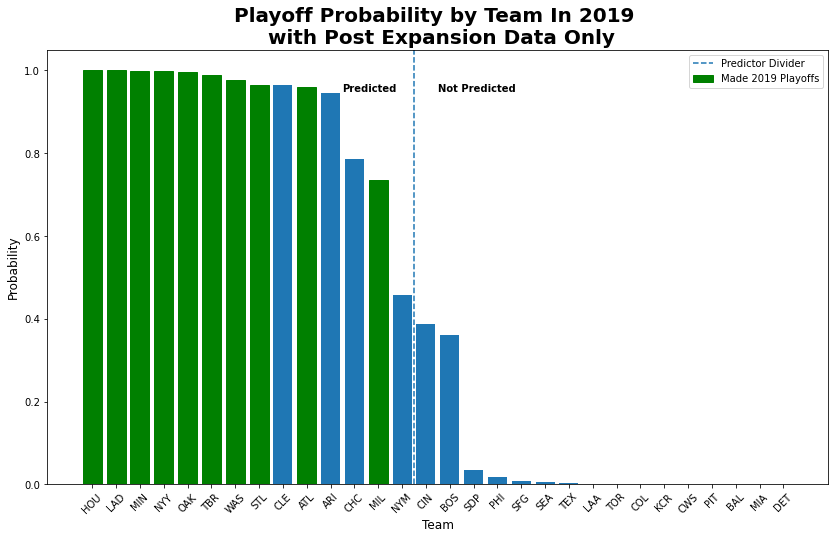

In [239]:
ax = plt.figure(figsize = (14, 8))

ax = plt.bar(pred_2019_post_exp['team'], pred_2019_post_exp['predicted_proba'])

# color the ones in 1, made playoff, green
for i in range(30):
    if pred_2019_post_exp['playoff_appearance'].reset_index(drop = True)[i] == 1:
        ax[i].set_color('g')

# Add a divider   
plt.axvline(13.5, linestyle='dashed')
plt.text(10.5, 0.95, s = 'Predicted', fontweight = 'bold')
plt.text(14.5, 0.95, s = 'Not Predicted', fontweight = 'bold')
plt.legend(labels = ['Predictor Divider', 'Made 2019 Playoffs'])

plt.title('Playoff Probability by Team In 2019 \n with Post Expansion Data Only', fontweight='bold', fontsize=20)
plt.ylabel('Probability', fontsize = 12)
plt.xlabel('Team', fontsize = 12)
plt.xticks(rotation = 45)
plt.show()

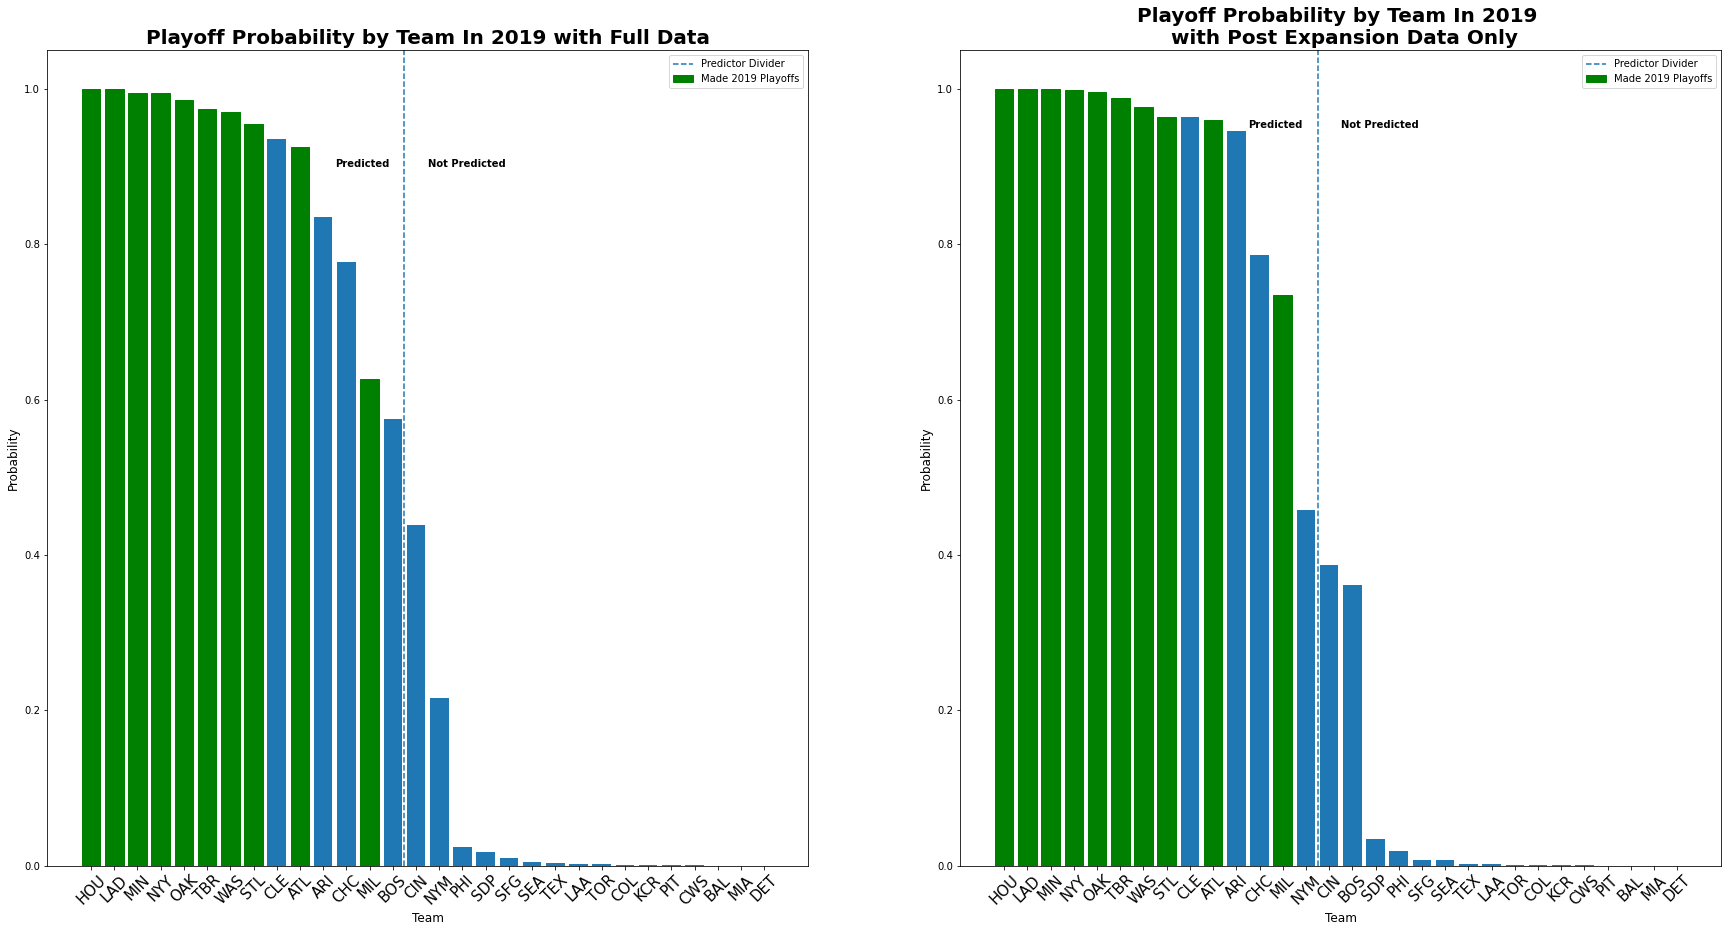

In [240]:
## Will plot two side to side for easeness

plt.subplots(1, 2, figsize = (30, 15))  

plt.subplot(1, 2, 1)
# indexed from 1 not 0


ax = plt.bar(pred_2019['team'], pred_2019['predicted_proba'])

# color the ones in 1, made playoff, green
for i in range(30):
    if pred_2019['playoff_appearance'].reset_index(drop = True)[i] == 1:
        ax[i].set_color('g')
        
# Add a divider       
plt.axvline(13.5, linestyle='dashed')
plt.text(10.5, 0.9, s = 'Predicted', fontweight = 'bold')
plt.text(14.5, 0.9, s = 'Not Predicted', fontweight = 'bold')
plt.legend(labels = ['Predictor Divider', 'Made 2019 Playoffs'])
        
plt.title('Playoff Probability by Team In 2019 with Full Data', fontweight='bold', fontsize=20)
plt.ylabel('Probability', fontsize = 12)
plt.xlabel('Team', fontsize = 12)
plt.xticks(rotation = 45, fontsize = 15)
# tried with alias graph4 but apparently aliasing sns.scatterplot doesnt do anything =]

plt.subplot(1, 2, 2)
#second graph with only top 10

ax = plt.bar(pred_2019_post_exp['team'], pred_2019_post_exp['predicted_proba'])

# color the ones in 1, made playoff, green
for i in range(30):
    if pred_2019_post_exp['playoff_appearance'].reset_index(drop = True)[i] == 1:
        ax[i].set_color('g')

# Add a divider   
plt.axvline(13.5, linestyle='dashed')
plt.text(10.5, 0.95, s = 'Predicted', fontweight = 'bold')
plt.text(14.5, 0.95, s = 'Not Predicted', fontweight = 'bold')
plt.legend(labels = ['Predictor Divider', 'Made 2019 Playoffs'])

plt.title('Playoff Probability by Team In 2019 \n with Post Expansion Data Only', fontweight='bold', fontsize=20)
plt.ylabel('Probability', fontsize = 12)
plt.xlabel('Team', fontsize = 12)
plt.xticks(rotation = 45, fontsize = 15)
plt.show()

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Overall performance did not change but one noticable shift in probability for MIL. The graph on the right was far more certain about MIL making in to playoff. There is always going to be some victims to the format of playoff but overall, every playoff team was predicted to have over 80% probability to make into playoff. Overall, the performances on unseen data for both models seem very good! 

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;There are future improvements that I could make on these models. I will try to BoarderlineSMOTE have it work in pipeline. Also I can further look into neighbours of best parameters of gridsearch to ensure they are indeed the best parameters. With multicollinearity out of the way, I can try K-Best as feature selection to see which features are selected automatically and see how that model performs compare to ones I have. Lastly, inspired by adjustment of threshold, I could pass in information on division and format of playoff and see if it improves on the performances of models.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Through this capstone project, I had a chance to webscrape my data, clean up the data, model using different machine learning and analyze my models. Webscraping and cleaning up the data presented bigger challenges than I expected. There were always minute problems pop up unexpectedly and finding fixes were not easy. Given the nature of the data I collected, it was very broad overview of how a season went for the team. Though I am very happy with the prediction power of my model, I had to find ways to combat the obvious flaws of my data and mitigate the shortcomings. I found some success and will update as I pick up more knowledge. 

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;This was a good project that I got to work on as a springboard to more baseball related data science projects. Once I tidy up and try more things, I would like to move on with more detailed data and neural network with a bit more sizable data. I plan on working on model that predicts next pitch from a pitcher so stay tuned. I have collected some parts of data already and once I have a bigger computing power during the holiday, I will dive into the topic. Thank you very much for taking your time to go through this lengthy workbook and hope you found my work interesting. I'd like to give big shoutouts to educator teams in BrainStation, Myles, Daniel, Bowen and Jenna answering questions I had! Please stay tuned for my next project and I welcome any suggestions and inputs!